# Global Egg Price Index
This notebook consolidates data processing, visualisation, and normalisation steps for building the Global Egg Price Index.

In [41]:

import pandas as pd
import matplotlib.pyplot as plt

# Set global plot style
plt.style.use("Solarize_Light2")
line_colour = "#D2691E"  # Rust/Orange colour
line_width = 1.3


In [13]:
!which python

/Users/eoinoreilly/miniconda3/envs/egg_index/bin/python


## 1. Fetch Latest EUR/USD from Frankfurter API

In [42]:

import requests

url = "https://api.frankfurter.app/1999-01-01..?to=USD&from=EUR"
response = requests.get(url)
data = response.json()

# Convert to DataFrame
df = pd.DataFrame(data["rates"]).T  # Transpose dates as rows
df.index = pd.to_datetime(df.index)
df.columns = ["EUR_USD"]

# Convert to monthly average
df_monthly = df.resample("ME").mean()

# Save to CSV
df_monthly.to_csv("../data/rates/eur_usd.csv")
print(df_monthly.head())


             EUR_USD
1999-01-31  1.160775
1999-02-28  1.120725
1999-03-31  1.087400
1999-04-30  1.069775
1999-05-31  1.058820


In [25]:
## 2. Load in data

In [43]:
# Load the original CSV
file_path = "../data/usa_data/egg_price_per_dozen_usa.csv"
df_us = pd.read_csv(file_path)

# Melt the dataframe to long format
df_long = df_us.melt(id_vars=["Year"], var_name="Month", value_name="Price")

# Drop missing price values (e.g., blank future months)
df_long.dropna(subset=["Price"], inplace=True)

# Map month names to numbers
month_map = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}
df_long["Month_Num"] = df_long["Month"].map(month_map)

# Create a proper datetime column
df_long["Date"] = pd.to_datetime(
    dict(year=df_long["Year"], month=df_long["Month_Num"], day=1)
)

# Sort by date chronologically
df_long = df_long.sort_values(by="Date")

# Reformat date to dd/mm/yyyy
df_long["Date"] = df_long["Date"].dt.strftime("%d/%m/%Y")

# Keep only Date and Price columns
df_final = df_long[["Date", "Price"]]

# Save to new CSV
output_file = "../data/usa_data/egg_price_reformatted.csv"
df_final.to_csv(output_file, index=False)

print(f"Reformatted and chronologically ordered CSV saved to {output_file}")


Reformatted and chronologically ordered CSV saved to ../data/usa_data/egg_price_reformatted.csv


## 1. US Egg Price Analysis

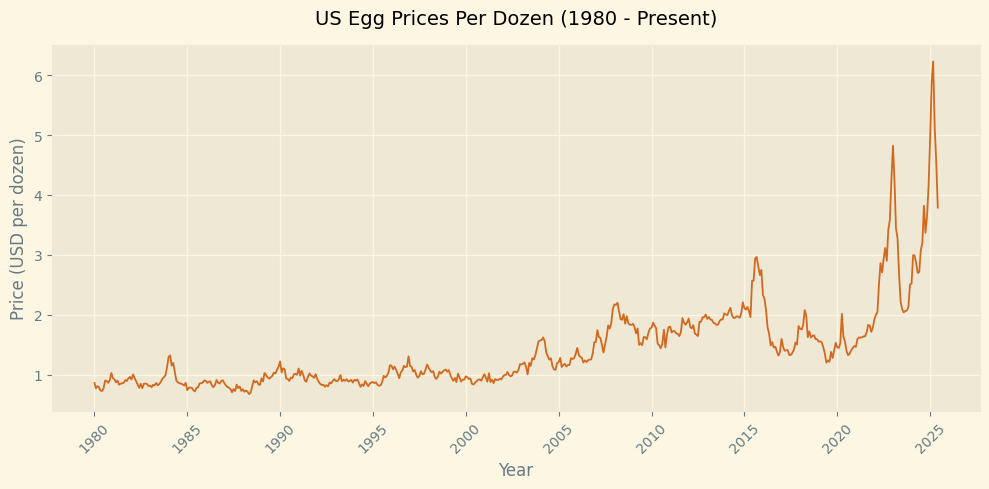

In [62]:

# Load the reformatted CSV
file_path = "../data/usa_data/egg_price_reformatted.csv"
df_us = pd.read_csv(file_path)

# Parse dates
df_us["Date"] = pd.to_datetime(df_us["Date"], format="%d/%m/%Y", dayfirst=True)
df_us["Price"] = pd.to_numeric(df_us["Price"], errors="coerce")

# Clean and sort
df_us = df_us.dropna(subset=["Date", "Price"]).sort_values("Date")

# 1️⃣ Full Historical Chart (1980 - Present)
plt.figure(figsize=(10, 5))
plt.plot(df["Date"], df["Price"], color=line_colour, linewidth=line_width)
plt.title("US Egg Prices Per Dozen (1980 - Present)", fontsize=14, pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Price (USD per dozen)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig("egg_prices_1980_present.png", dpi=300)  # Save as PNG
#plt.close()
plt.show()


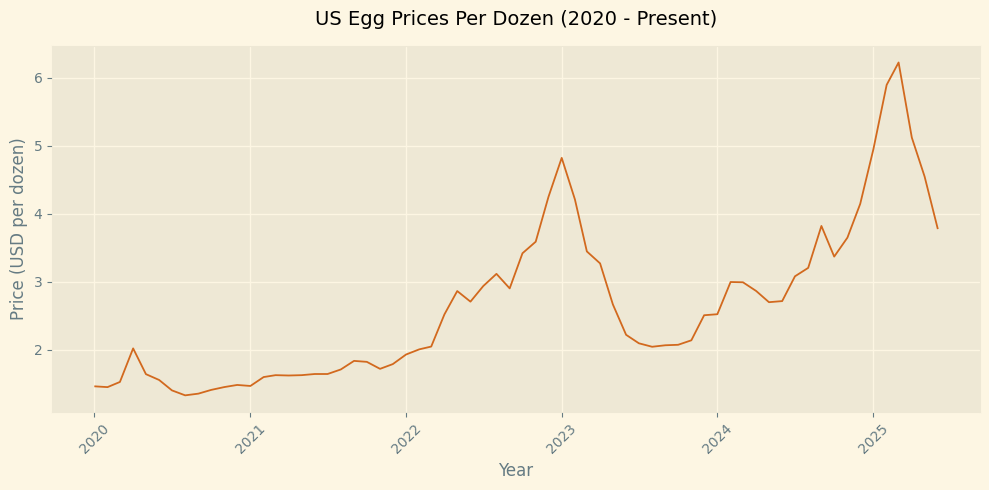

In [63]:
# 2️⃣ Recent Chart (2020 - Present)
df_recent = df[df["Date"] >= "2020-01-01"]
plt.figure(figsize=(10, 5))
plt.plot(df_recent["Date"], df_recent["Price"], color=line_colour, linewidth=line_width)
plt.title("US Egg Prices Per Dozen (2020 - Present)", fontsize=14, pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Price (USD per dozen)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig("egg_prices_2020_present.png", dpi=300)  # Save as PNG
#plt.close()
plt.show()


## 2. Ireland Egg Price Analysis

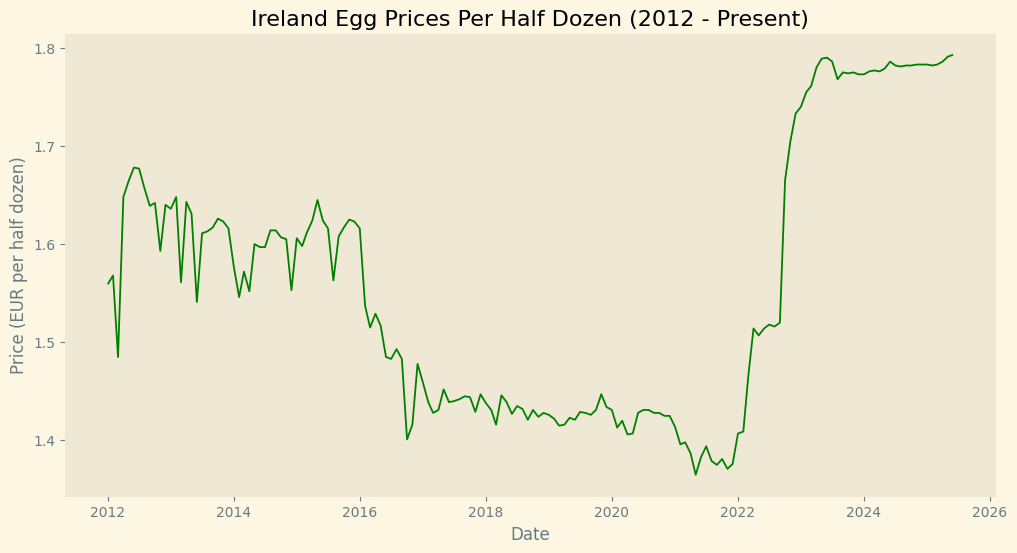

In [77]:
# Convert date and keep original price (per half dozen)
df_ie["Date"] = pd.to_datetime(df_ie["Month"], format="%Y %B")
df_ie = df_ie.sort_values("Date")

# Plot full range (per half dozen)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_ie["Date"], df_ie["VALUE"], color="green", linewidth=line_width)
ax.set_title("Ireland Egg Prices Per Half Dozen (2012 - Present)", fontsize=16)
ax.set_xlabel("Date")
ax.set_ylabel("Price (EUR per half dozen)")
ax.grid(False)
plt.show()

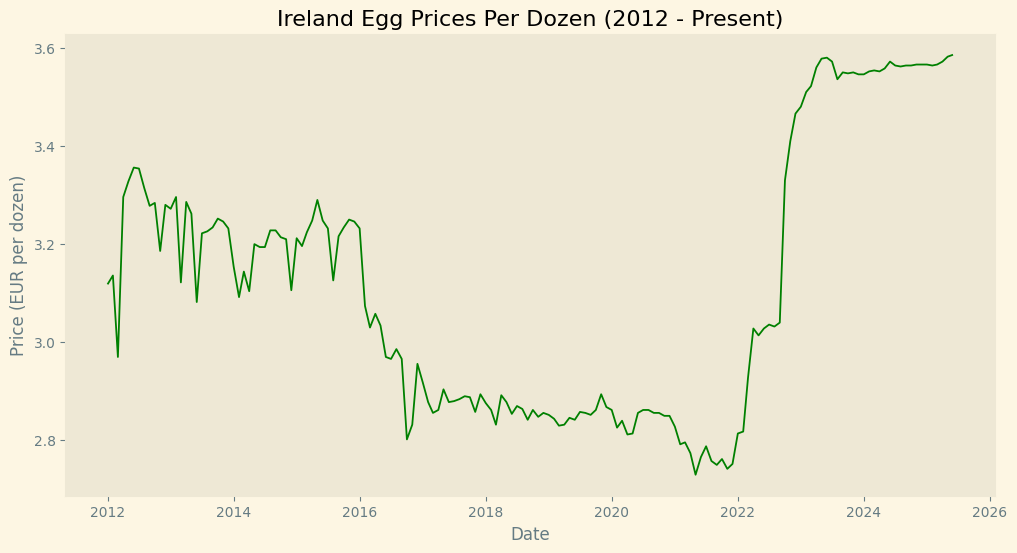

In [74]:

file_path_ie = "../data/ie_data/CPM12.20250802T120846.csv"
df_ie = pd.read_csv(file_path_ie)

# Convert date and price
df_ie["Date"] = pd.to_datetime(df_ie["Month"], format="%Y %B")
df_ie["Price_EUR_Dozen"] = df_ie["VALUE"] * 2
df_ie = df_ie.sort_values("Date")

# Plot full range
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_ie["Date"], df_ie["Price_EUR_Dozen"], color="green", linewidth=line_width)
ax.set_title("Ireland Egg Prices Per Dozen (2012 - Present)", fontsize=16)
ax.set_xlabel("Date")
ax.set_ylabel("Price (EUR per dozen)")
ax.grid(False)
plt.show()


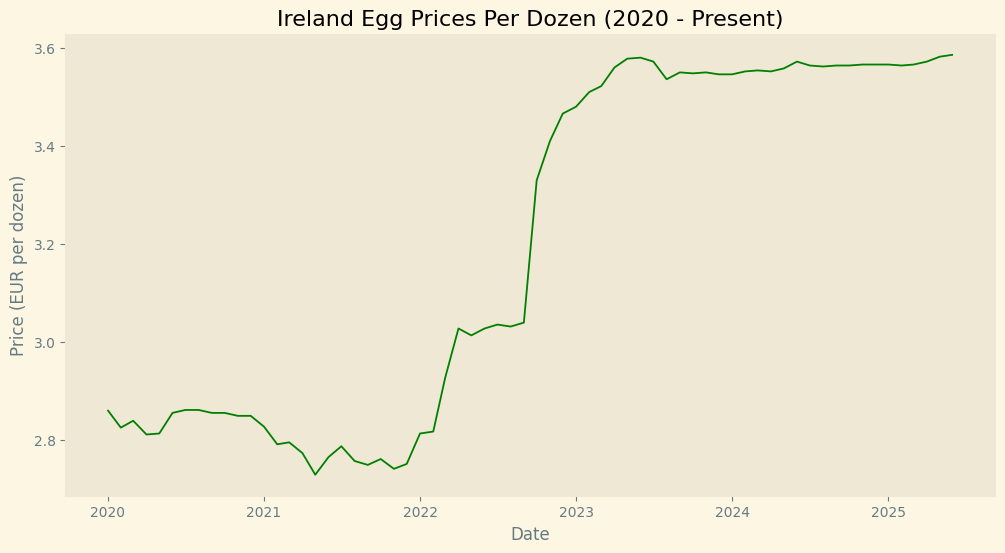

In [75]:
# Plot 2020 onwards
df_ie_zoom = df_ie[df_ie["Date"] >= "2020-01-01"]
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_ie_zoom["Date"], df_ie_zoom["Price_EUR_Dozen"], color="green", linewidth=line_width)
ax.set_title("Ireland Egg Prices Per Dozen (2020 - Present)", fontsize=16)
ax.set_xlabel("Date")
ax.set_ylabel("Price (EUR per dozen)")
ax.grid(False)
plt.show()

## 3. FX Normalisation (EUR to USD)

FX DataFrame columns: Index(['Unnamed: 0', 'EUR_USD'], dtype='object')
        Date   EUR_USD
0 1999-02-01  1.160775
1 1999-03-01  1.120725
2 1999-04-01  1.087400
3 1999-05-01  1.069775
4 1999-06-01  1.058820


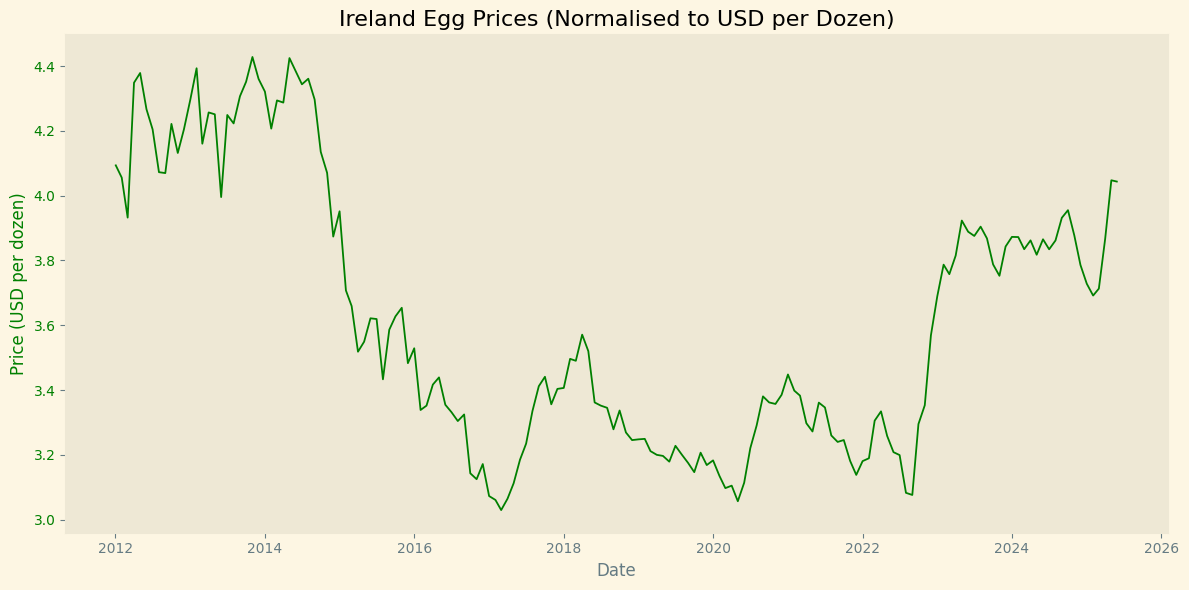

In [76]:
# Load EUR/USD exchange rates
fx_file = "../data/rates/eur_usd.csv"
df_fx = pd.read_csv(fx_file)

print("FX DataFrame columns:", df_fx.columns)  # Debug check

# Rename columns properly
if "Unnamed: 0" in df_fx.columns:
    df_fx.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
else:
    df_fx.rename(columns={df_fx.columns[0]: "Date"}, inplace=True)

# Ensure EUR_USD column is named correctly
if "EUR_USD" not in df_fx.columns:
    df_fx.rename(columns={df_fx.columns[1]: "EUR_USD"}, inplace=True)

# Convert Date to datetime and adjust to month-start
df_fx["Date"] = pd.to_datetime(df_fx["Date"])
df_fx["Date"] = df_fx["Date"] - pd.offsets.MonthEnd(0) + pd.offsets.MonthBegin(1)

print(df_fx.head())  # Confirm correct structure: Date | EUR_USD

# Merge FX with egg price data
df_ie = pd.merge(df_ie, df_fx, on="Date", how="left")

# Forward fill FX rates (if gaps exist)
df_ie["EUR_USD"] = df_ie["EUR_USD"].ffill()

# Calculate USD price
df_ie["Price_USD_Dozen"] = df_ie["Price_EUR_Dozen"] * df_ie["EUR_USD"]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_ie["Date"], df_ie["Price_USD_Dozen"], color="green", linewidth=line_width)
ax.set_title("Ireland Egg Prices (Normalised to USD per Dozen)", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Price (USD per dozen)", fontsize=12, color="green")
ax.tick_params(axis="y", labelcolor="green")
ax.tick_params(axis="both", labelsize=10)
ax.grid(False)  # No gridlines

plt.tight_layout()
plt.show()



## USA vs IE egg prices (in USD)

In [70]:
print("Ireland DF Columns:", df_ie.columns)

Ireland DF Columns: Index(['STATISTIC Label', 'Month', 'Consumer Item', 'UNIT', 'VALUE', 'Date',
       'Price_EUR_Dozen', 'EUR_USD', 'Price_USD_Dozen'],
      dtype='object')


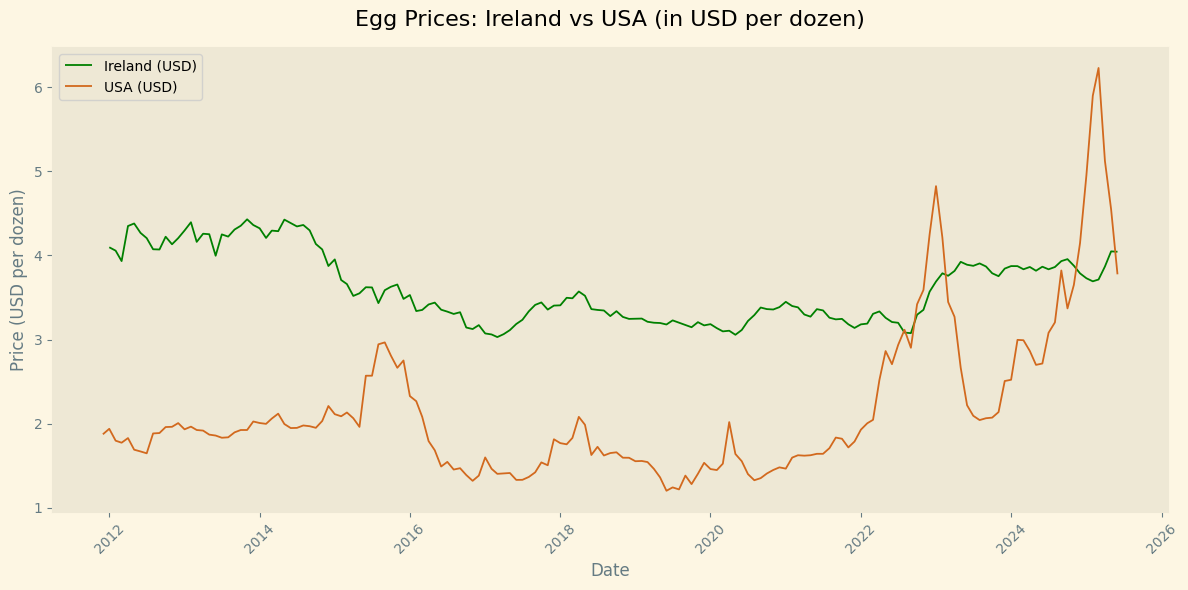

In [73]:
# Ensure US DataFrame has consistent naming
df_us.rename(columns={"Price": "Price_USD_Dozen"}, inplace=True)

# Extract Ireland USD prices
df_ie_usd = df_ie[["Date", "Price_USD_Dozen"]]

# Filter US data to match Ireland's date range
start_date = df_ie_usd["Date"].min()
end_date = df_ie_usd["Date"].max()
df_us_filtered = df_us[(df_us["Date"] >= start_date) & (df_us["Date"] <= end_date)]

# Merge for comparison
df_compare = pd.merge(
    df_ie_usd.rename(columns={"Price_USD_Dozen": "Ireland_USD"}),
    df_us_filtered[["Date", "Price_USD_Dozen"]].rename(columns={"Price_USD_Dozen": "USA_USD"}),
    on="Date",
    how="inner"
)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_compare["Date"], df_compare["Ireland_USD"], label="Ireland (USD)", color="green", linewidth=line_width)
plt.plot(df_compare["Date"], df_compare["USA_USD"], label="USA (USD)", color=line_colour, linewidth=line_width)

plt.title("Egg Prices: Ireland vs USA (in USD per dozen)", fontsize=16, pad=15)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD per dozen)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()
